# Mode overlap integral between a waveguide mode and a Gaussian mode

The evaluation of the overlap integral quantifies the level of matching between two optical field distributions. It is particularly useful, for example, in determining the coupling efficiency to the desired waveguide mode when connecting an optical fiber to an edge coupler.

Tidy3D facilitates the analytical computation of field distributions for different beam types including Gaussian beam, astigmatic Gaussian beam, and plane wave. This feature enables swift calculation of mode overlap integral with another mode, likely determined through a mode solver analysis. 

This notebook presents the optimization of coupling efficiency between a single-mode fiber (represented by a Gaussian mode field) and a silicon edge coupler. The focus is to highlight the usage of built-in functions for the analytical computation of the Gaussian beam profile and overlap integral calculation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

## Generate the Gaussian Beam Profile

The Gaussian beam is analytically defined by

$$
E(x,y,z) = \frac{w_0}{w(z)} \exp\left[-\frac{x^2+y^2}{w(z)^2}\right] \exp\Biggl\{ i\Bigl( k_0 z + \frac{k_0(x^2+y^2)}{2R(z)} - \psi(z)\Bigr) \Biggr\},
$$

where the beam parameters are defined as follows:

Beam radius:

  $$
  w(z) = w_0 \sqrt{1+\left(\frac{z+z_0}{z_R}\right)^2},
  $$

  with $w_0$ as the waist radius and $z_0$ as the waist distance.

Rayleigh range:

  $$
  z_R = \frac{k_0 w_0^2}{2}.
  $$

Radius of curvature:

  $$
  R(z) = \frac{(z+z_0)^2+z_R^2}{z+z_0}.
  $$

Gouy phase:

  $$
  \psi(z) = \arctan\!\Bigl(\frac{z+z_0}{z_R}\Bigr) - \arctan\!\Bigl(\frac{z_0}{z_R}\Bigr).
  $$

A Gaussian beam field profile can be generated directly through [GaussianBeamProfile](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GaussianBeamProfile.html). Similarly, an astigmatic Gaussian beam profile can be generated through [AstigmaticGaussianBeamProfile](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.AstigmaticGaussianBeamProfile.html) and a plane wave profile can be generated through [PlaneWaveBeamProfile](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWaveBeamProfile.html). 

In this notebook, we want to optimize the coupling between an SMF-28 and a 220 nm SOI edge coupler by adjusting the waveguide width at the end of the edge coupler. This requires us to perform mode analysis on the waveguide cross section with varying widths and then perform mode overlap integral with the fiber mode. For SMF-28, the mode field diameter at 1550 nm is about 10.5 μm. Therefore, we can represent the mode field with a Gaussian beam with a `waist_radius` of 5.25 μm.

In [2]:
lda0 = 1.55  # wavelength of interest
freq0 = td.C_0 / lda0  # frequency of interest
r_beam = 5.25  # beam radius
size = 6 * r_beam  # plane size for the beam profile

In order to accurately capture the full profile of the Gaussian beam, it is imperative to ensure the plane size is sufficiently large, at least a few times larger than the beam size. The `size` argument also expects one of the values to be 0. The direction with a zero size is taken as the propagation axis. For example, if `size=(size_x, size_y, 0)`, the Gaussian beam is propagating in the $z$ direction. Additional arguments such as `angle_theta` and `angle_phi` can be specified if the desired propagation direction is not parallel to one of the Cartesian axes, similar to defining a regular [GaussianBeam](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GaussianBeam.html) source in FDTD.

Additionally, it's necessary to align the polarization angle with the desired waveguide mode for effective coupling. In this particular scenario, the target is coupling to the fundamental TE mode that is polarized in the y-direction. 

The `resolution` parameter is crucial as it defines the sampling resolution and it needs to be appropriately high to ensure precision.

In [3]:
# generate a Gaussian beam
gaussian_beam = td.GaussianBeamProfile(
    waist_radius=r_beam,
    pol_angle=np.pi / 2,  # polarized in the y direction for coupling to the TE mode
    size=(size, size, 0),
    resolution=200,
    freqs=[freq0],
)

Once the beam is generated, we can visualize the field profile.

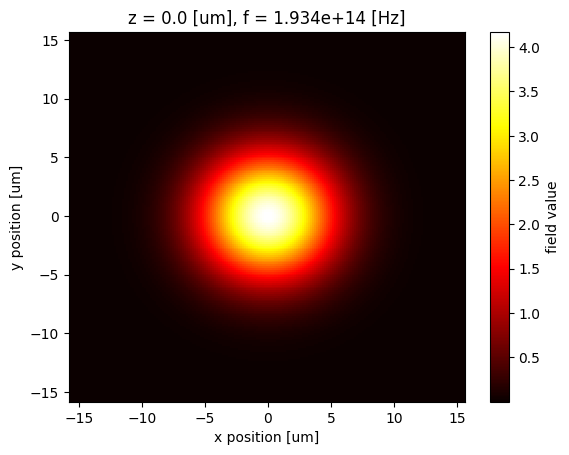

In [4]:
gaussian_beam.field_data.Ey.abs.plot(cmap="hot", x="x", y="y")
plt.show()

## Conducting Mode Analysis on the Waveguide

We will proceed by performing a mode analysis on the waveguide structure at the end facet of the edge coupler. Our aim is to sweep a range of waveguide widths to identify the optimal value, one which would result in the highest coupling efficiency. To accomplish this, we first define a function `make_mode_solver`. This function takes the waveguide width as an input parameter and returns a [ModeSolver]() instance.

In [5]:
# materials used
si = td.material_library["cSi"]["Li1993_293K"]
sio2 = td.material_library["SiO2"]["Horiba"]

# thickness of the waveguide
h = 0.22


def make_mode_solver(w):
    waveguide = td.Structure(geometry=td.Box(center=(0, 0, 0), size=(h, w, td.inf)), medium=si)

    sim = td.Simulation(
        center=(0, 0, 0),
        size=(size, size, 1),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=25, wavelength=lda0),
        structures=[waveguide],
        run_time=1e-12,
        medium=sio2,
        symmetry=(1, -1, 0),  # symmetry for the fundamental TE mode
    )

    mode_spec = td.ModeSpec(num_modes=1, target_neff=3.5)
    mode_solver = ModeSolver(
        simulation=sim,
        plane=td.Box(center=(0, 0, 0), size=(size, size, 0)),
        mode_spec=mode_spec,
        freqs=[freq0],
    )

    return mode_solver

We investigate the waveguide width from 100 to 200 nm in increment of 10 nm. All 11 mode solvers are submitted via a [Batch]() to run in parallel. 

In [6]:
w_list = np.linspace(0.1, 0.2, 11)
mode_solvers = {f"w={w:.2f}": make_mode_solver(w) for w in w_list}

batch = web.Batch(simulations=mode_solvers, verbose=True)
batch_results = batch.run(path_dir="data")

Output()

08:29:34 CEST Started working on Batch containing 11 tasks.

08:29:44 CEST Maximum FlexCredit cost: 0.053 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

08:29:53 CEST Batch complete.

Output()

## Mode Overlap Integral

After the batch mode solving, we are ready to perform the mode overlap integral (modal decomposition) between the waveguide mode and the Gaussian mode for each waveguide width. This can be achieved easily with the built-in `outer_dot` method, which implements

$$
\frac{1}{4} \int 
\left( 
    \mathbf{E}_0 \times \mathbf{H}_1^*
    + 
    \mathbf{H}_0^* \times \mathbf{E}_1
\right) \cdot
\, d\mathbf {S}.
$$


After the overlap integrals are calculated, we can plot the coupling efficiency as a function of the waveguide width to identify the optimal value. In this case, the optimal width is between 130 and 140 nm. 

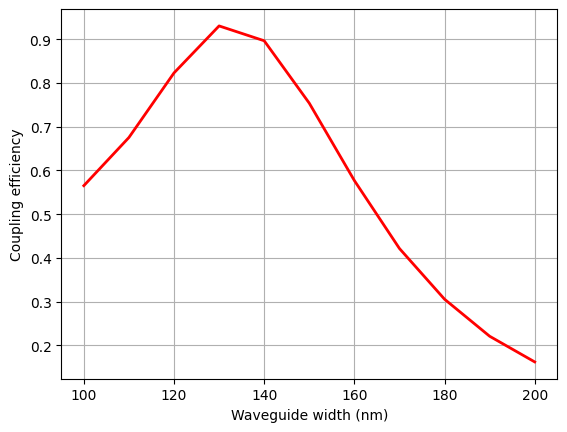

In [7]:
overlap = [
    batch_results[f"w={w:.2f}"].outer_dot(gaussian_beam.field_data).values.squeeze() for w in w_list
]

plt.plot(1e3 * w_list, np.abs(overlap) ** 2, "r", linewidth=2)
plt.xlabel("Waveguide width (nm)")
plt.ylabel("Coupling efficiency")
plt.grid()

For instance, we can examine the mode profile of the waveguide with a width of 130 nm.

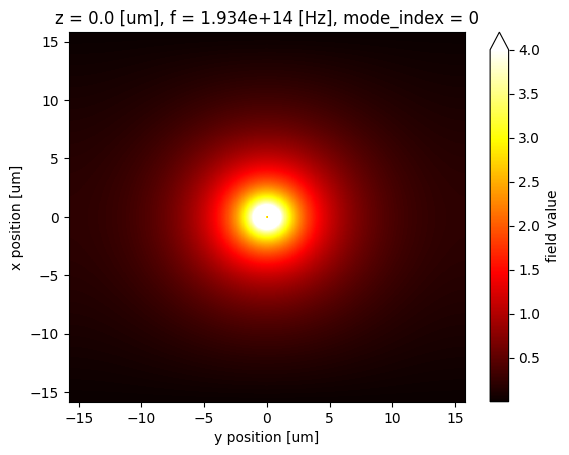

In [8]:
optimal_mode = batch_results["w=0.13"]
optimal_mode.Ey.abs.plot(vmax=4, cmap="hot")
plt.show()

After determining the optimal waveguide geometry, we can examine the impact of misalignment on the coupling efficiency. This scenario becomes relevant as the fiber is often not perfectly aligned with the waveguide in practical situations. To accomplish this, we will employ the `translated_copy(vector)` method, which shifts the mode profile in both the $x$ and $y$ directions. Then we can calculate the overlap integral between the Gaussian beam and the shifted mode profile.

As anticipated, the results indicate that the coupling efficiency diminishes when the waveguide mode and Gaussian beam become misaligned.

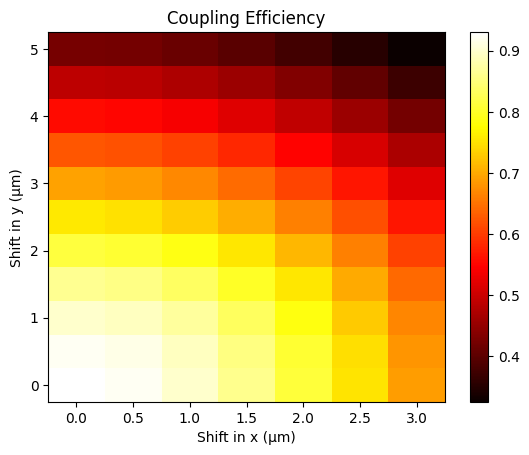

In [9]:
shift_x_list = np.linspace(0, 3, 7)
shift_y_list = np.linspace(0, 5, 11)

# use a nested list comprehension to build the array of overlaps
shifted_overlap = np.array(
    [
        [
            optimal_mode.translated_copy(vector=(shift_x, shift_y, 0))
            .outer_dot(gaussian_beam.field_data)
            .values.squeeze()
            for shift_x in shift_x_list
        ]
        for shift_y in shift_y_list
    ]
)

# plot the coupling efficiency
plt.pcolormesh(shift_x_list, shift_y_list, np.abs(shifted_overlap) ** 2, cmap="hot")
plt.xlabel("Shift in x (μm)")
plt.ylabel("Shift in y (μm)")
plt.title("Coupling Efficiency")
plt.colorbar()
plt.show()

## Final Remarks

In this example, we set the size of the Gaussian mode plane and waveguide mode plane to be identical. This is not strictly required for the overlap calculation. As long as both planes are sufficiently large and the mode profiles decay to zero at the boundaries, the result will be accurate. The discretization grids of the two profiles are not required to be identical either, since the `outer_dot` method will automatically interpolate the data. However, we need to ensure both grids are sufficiently fine for the profiles to be accurate and to minimize discretization error in the integration.